# Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.3 MB/s eta 0:00:00


# Notebook

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import transformers
from transformers import TFBertModel

from tqdm.auto import tqdm
from sklearn.metrics import classification_report, precision_recall_curve, \
    PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay

In [5]:
train_dir = '/content/drive/My Drive/Course/Spring Semester/msba6461_Advanced AI for Business Applications/homework/hw1/FB_posts_labeled.txt'

df = pd.read_csv(train_dir, sep='\t')
df['category'] = df.iloc[:, 2:].idxmax(axis=1)
df

,postId,message,Appreciation,Complaint,Feedback,category
0,126016648090_10150802142013091,Great ! ;),1,0,0,Appreciation
1,108381603303_10151136215833304,YUM! YUM!,1,0,0,Appreciation
2,108381603303_3913438087739,Yummm :)),1,0,0,Appreciation
3,110455108974424_343049739048292,sweet,1,0,0,Appreciation
4,110455108974424_350358541650745,nice,1,0,0,Appreciation
...,...,...,...,...,...,...
7956,179590995428478_390650150989227,Oregon locations,0,1,0,Complaint
7957,6806028948_10151298595908949,Just had two very long and very expensive flig...,0,1,0,Complaint
7958,77978885595_10152286635360596,pet smart #1756 Flowery branch ga really gave...,0,1,0,Complaint
7959,125472670805257_397218893630632,having terrible trouble getting help from delt...,0,1,0,Complaint


<Axes: >

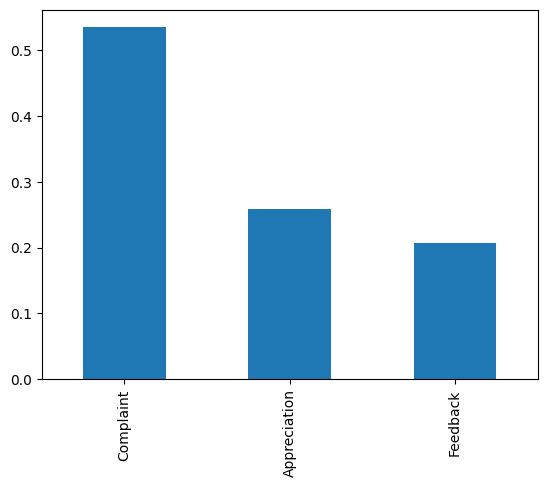

In [6]:
df['category'].value_counts(normalize=True).plot(kind='bar')

## Preparing Data

In [7]:
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 512

def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['message'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=MAX_LENGTH, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks


X_input_ids = np.zeros((len(df), MAX_LENGTH))
X_attn_masks = np.zeros((len(df), MAX_LENGTH))
    
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [8]:
labels = df.iloc[:, 2:-1].values
labels

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [9]:
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.int64, name=None))>

In [10]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {'input_ids': input_ids, 'attention_mask': attn_masks}, labels

dataset = dataset.map(SentimentDatasetMapFunction) # converting to required format for tensorflow dataset
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.int64, name=None))>

### Shuffle

In [11]:
new_dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor
p = 0.8
train_size = int((len(df)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

train_dataset = new_dataset.take(train_size)
val_dataset = new_dataset.skip(train_size)

## Modeling

In [11]:
base_model = TFBertModel.from_pretrained('bert-base-uncased') # bert base model with pretrained weights
base_model.trainable = False  # Freeze the pre-trained layer

# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='attention_mask', dtype='int32')

bert_embds = base_model.bert(input_ids, attention_mask=attn_masks, training=False)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(768, name='intermediate_layer')(bert_embds)
intermediate_layer = tf.keras.layers.BatchNormalization()(intermediate_layer)
intermediate_layer = tf.keras.layers.Activation('relu')(intermediate_layer)
intermediate_layer = tf.keras.layers.Dropout(0.2)(intermediate_layer)

intermediate_layer2 = tf.keras.layers.Dense(384, name='intermediate_layer2')(intermediate_layer)
intermediate_layer2 = tf.keras.layers.BatchNormalization()(intermediate_layer2)
intermediate_layer2 = tf.keras.layers.Activation('relu')(intermediate_layer2)
intermediate_layer2 = tf.keras.layers.Dropout(0.2)(intermediate_layer2)

intermediate_layer3 = tf.keras.layers.Dense(192, name='intermediate_layer3')(intermediate_layer2)
intermediate_layer3 = tf.keras.layers.BatchNormalization()(intermediate_layer3)
intermediate_layer3 = tf.keras.layers.Activation('relu')(intermediate_layer3)
intermediate_layer3 = tf.keras.layers.Dropout(0.2)(intermediate_layer3)

output_layer = tf.keras.layers.Dense(3, activation='softmax', name='output_layer')(intermediate_layer3) # softmax -> calcs probs of classes

model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [12]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f7d4c29f8b0> True
<keras.engine.input_layer.InputLayer object at 0x7f7d4fe2c8b0> True
<transformers.models.bert.modeling_tf_bert.TFBertMainLayer object at 0x7f7d4c29a340> False
<keras.layers.core.dense.Dense object at 0x7f7d4408b340> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f7df6446220> True
<keras.layers.core.activation.Activation object at 0x7f7d3c16c670> True
<keras.layers.regularization.dropout.Dropout object at 0x7f7d3c0ed520> True
<keras.layers.core.dense.Dense object at 0x7f7df62dd880> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f7d3c058760> True
<keras.layers.core.activation.Activation object at 0x7f7d30779e20> True
<keras.layers.regularization.dropout.Dropout object at 0x7f7d3c023550> True
<keras.layers.core.dense.Dense object at 0x7f7d3c0bbb80> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f7d4407e160> Tr

In [13]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [14]:
epochs = 50
model_ver = 5
model_path = f'/content/drive/My Drive/Course/Spring Semester/msba6461_Advanced AI for Business Applications/homework/hw1/FB_NLP_{model_ver}.h5'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=2, mode='min', factor= 0.5, min_lr= 1e-6, verbose=1),
    ModelCheckpoint(model_path, 
                    verbose=1, 
                    monitor='val_loss', 
                    save_best_only=True,
                    mode='min')  # save traning progress
]

history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = epochs,
    callbacks = callbacks,
)

Epoch 1/50
397/397 [==============================] - ETA: 0s - loss: 0.8856 - accuracy: 0.6236
Epoch 1: val_loss improved from inf to 0.78256, saving model to /content/drive/My Drive/Course/Spring Semester/msba6461_Advanced AI for Business Applications/homework/hw1/FB_NLP_5.h5
397/397 [==============================] - 324s 787ms/step - loss: 0.8856 - accuracy: 0.6236 - val_loss: 0.7826 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 2/50
397/397 [==============================] - ETA: 0s - loss: 0.6787 - accuracy: 0.7236
Epoch 2: val_loss improved from 0.78256 to 0.62665, saving model to /content/drive/My Drive/Course/Spring Semester/msba6461_Advanced AI for Business Applications/homework/hw1/FB_NLP_5.h5
397/397 [==============================] - 332s 835ms/step - loss: 0.6787 - accuracy: 0.7236 - val_loss: 0.6267 - val_accuracy: 0.7494 - lr: 1.0000e-04
Epoch 3/50
397/397 [==============================] - ETA: 0s - loss: 0.6506 - accuracy: 0.7415
Epoch 3: val_loss improved from 0.6266

Text(0.5, 0.98, 'Training Report')

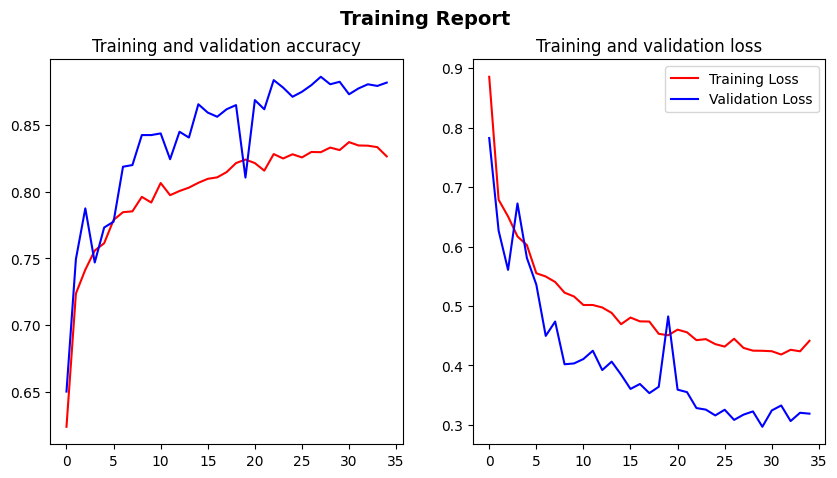

In [15]:
# Plot the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.suptitle('Training Report', fontsize=14, fontweight='bold')

## Fine Tune entire model without freezing

In [13]:
# Make sure to unfreeze the base model
model.layers[2].trainable = True

for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fb6a418d880> True
<keras.engine.input_layer.InputLayer object at 0x7fb6a418df10> True
<transformers.models.bert.modeling_tf_bert.TFBertMainLayer object at 0x7fb6a41a4e80> True
<keras.layers.core.dense.Dense object at 0x7fb6a41a4b20> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb697364220> True
<keras.layers.core.activation.Activation object at 0x7fb697364af0> True
<keras.layers.regularization.dropout.Dropout object at 0x7fb697364a90> True
<keras.layers.core.dense.Dense object at 0x7fb697364dc0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb6973741f0> True
<keras.layers.core.activation.Activation object at 0x7fb697374ac0> True
<keras.layers.regularization.dropout.Dropout object at 0x7fb697374a60> True
<keras.layers.core.dense.Dense object at 0x7fb697374fa0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb6973771c0> Tru

In [14]:
optim = tf.keras.optimizers.Adam(learning_rate=5e-5) # Low learning rate
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [15]:
epochs=10
model_path = f'/content/drive/My Drive/Course/Spring Semester/msba6461_Advanced AI for Business Applications/homework/hw1/FB_NLP_{model_ver}.h5'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=1, mode='min', factor= 0.5, min_lr= 1e-6, verbose=1),
    ModelCheckpoint(model_path, 
                    verbose=1, 
                    monitor='val_loss', 
                    save_best_only=True,
                    mode='min')  # save traning progress
]

history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = epochs,
    callbacks = callbacks,
)

Epoch 1/10
397/397 [==============================] - ETA: 0s - loss: 0.4755 - accuracy: 0.8259
Epoch 1: val_loss improved from inf to 0.25844, saving model to /content/drive/My Drive/Course/Spring Semester/msba6461_Advanced AI for Business Applications/homework/hw1/FB_NLP_5.h5
397/397 [==============================] - 745s 2s/step - loss: 0.4755 - accuracy: 0.8259 - val_loss: 0.2584 - val_accuracy: 0.9000 - lr: 5.0000e-05
Epoch 2/10
397/397 [==============================] - ETA: 0s - loss: 0.2987 - accuracy: 0.8947
Epoch 2: val_loss improved from 0.25844 to 0.13290, saving model to /content/drive/My Drive/Course/Spring Semester/msba6461_Advanced AI for Business Applications/homework/hw1/FB_NLP_5.h5
397/397 [==============================] - 698s 2s/step - loss: 0.2987 - accuracy: 0.8947 - val_loss: 0.1329 - val_accuracy: 0.9581 - lr: 5.0000e-05
Epoch 3/10
397/397 [==============================] - ETA: 0s - loss: 0.1860 - accuracy: 0.9424
Epoch 3: val_loss improved from 0.13290 to 0

Text(0.5, 0.98, 'Training Report')

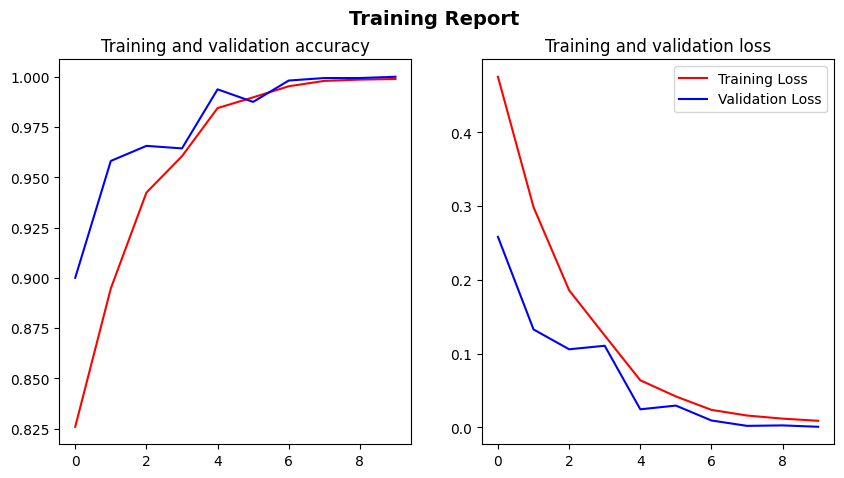

In [16]:
# Plot the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.suptitle('Training Report', fontsize=14, fontweight='bold')

# Evalutaion

In [17]:
new_dataset = dataset.batch(16, drop_remainder=True)  # Don't shuffle the dataset
p = 0.8
train_size = int((len(df)//16)*p) 

train_dataset = new_dataset.take(train_size)
val_dataset = new_dataset.skip(train_size)

In [18]:
prediction = model.predict(val_dataset)
print(prediction)
y_pred = prediction.argmax(axis=1).tolist()

y = np.concatenate([y for x, y in val_dataset], axis=0)
y_true = y.argmax(axis=1).tolist()

100/100 [==============================] - 61s 587ms/step
[[9.9936026e-01 4.0486752e-04 2.3493869e-04]
 [9.9929523e-01 4.1444998e-04 2.9024971e-04]
 [9.9948573e-01 2.6722151e-04 2.4699647e-04]
 ...
 [1.9927885e-04 1.4226696e-03 9.9837804e-01]
 [7.2780676e-05 9.9959749e-01 3.2968080e-04]
 [3.0002304e-04 9.9871063e-01 9.8939927e-04]]


In [19]:
print(classification_report(y_true, y_pred, target_names=['Appreciation', 'Complaint', 'Feedback'], digits=4, output_dict=False))

              precision    recall  f1-score   support

Appreciation     1.0000    1.0000    1.0000       328
   Complaint     0.9990    0.9990    0.9990      1035
    Feedback     0.9958    0.9958    0.9958       237

    accuracy                         0.9988      1600
   macro avg     0.9983    0.9983    0.9983      1600
weighted avg     0.9988    0.9988    0.9988      1600



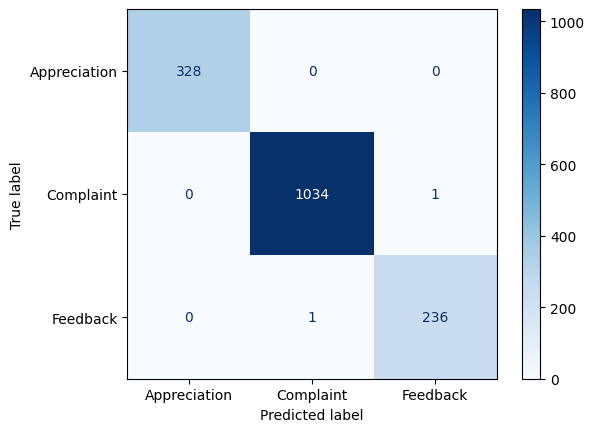

In [20]:
# Confusion Matrix
disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                               display_labels=['Appreciation', 'Complaint', 'Feedback'], 
                                               cmap=plt.cm.Blues)
plt.show()

# Prediction

In [12]:
# Initiate the trained model and tokenizer
model_ver = 5
model = tf.keras.models.load_model(f'/content/drive/My Drive/Course/Spring Semester/msba6461_Advanced AI for Business Applications/homework/hw1/FB_NLP_{model_ver}.h5')
# model = tf.keras.models.load_model(f'FB_NLP_{model_ver}.h5', compile=False)
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 512

In [21]:
test_dir = '/content/drive/My Drive/Course/Spring Semester/msba6461_Advanced AI for Business Applications/homework/hw1/FB_posts_unlabeled.txt'
# test_dir = 'FB_posts_unlabeled.txt'

df_unlabel = pd.read_csv(test_dir, sep='\t')
df_unlabel

,postId,message
0,108381603303_10151119973393304,Love. It. To
1,115568331790246_371841206162956,NICE
2,115568331790246_515044031842672,Congrats
3,147285781446_10151010892176447,Awesome!
4,159616034235_10150639103634236,Award
...,...,...
2034,179590995428478_422375854483323,"you guys are terrible, holding goverment check..."
2035,125472670805257_525103854175468,as i platinum elite member of delta and a loya...
2036,179590995428478_377568608964048,Really?
2037,179590995428478_341070505947192,Horrible decision.


In [22]:
def prediction_pipeline(input_text):
    token = tokenizer.encode_plus(
        input_text,
        padding='max_length', 
        max_length=MAX_LENGTH, 
        truncation=True, 
        add_special_tokens=True,
        return_tensors='tf'
    )

    processed_data =  {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

    result = model.predict(processed_data, verbose=0)
    result = (result == result.max(axis=1)[:,None]).astype(int)[0].tolist()
    return result

# Show the progress bar for apply function
tqdm.pandas()

df_unlabel[['Appreciation_pred', 'Complaint_pred', 'Feedback_pred']] = df_unlabel.progress_apply(lambda x: prediction_pipeline(x['message']), axis=1, result_type='expand')
df_unlabel

  0%|          | 0/2039 [00:00<?, ?it/s]

,postId,message,Appreciation_pred,Complaint_pred,Feedback_pred
0,108381603303_10151119973393304,Love. It. To,1,0,0
1,115568331790246_371841206162956,NICE,1,0,0
2,115568331790246_515044031842672,Congrats,1,0,0
3,147285781446_10151010892176447,Awesome!,1,0,0
4,159616034235_10150639103634236,Award,1,0,0
...,...,...,...,...,...
2034,179590995428478_422375854483323,"you guys are terrible, holding goverment check...",0,1,0
2035,125472670805257_525103854175468,as i platinum elite member of delta and a loya...,0,1,0
2036,179590995428478_377568608964048,Really?,0,1,0
2037,179590995428478_341070505947192,Horrible decision.,0,1,0


In [23]:
df_final = df_unlabel.iloc[:, np.r_[0, 2:5]]
df_final.head()

,postId,Appreciation_pred,Complaint_pred,Feedback_pred
0,108381603303_10151119973393304,1,0,0
1,115568331790246_371841206162956,1,0,0
2,115568331790246_515044031842672,1,0,0
3,147285781446_10151010892176447,1,0,0
4,159616034235_10150639103634236,1,0,0


In [24]:
df_final.to_csv(f'/content/drive/My Drive/Course/Spring Semester/msba6461_Advanced AI for Business Applications/homework/hw1/tf_bert_submission_{model_ver}.csv', index=False)
# df_final.to_csv(f'tf_bert_submission_{model_ver}.csv', index=False)